<a href="https://colab.research.google.com/github/lokeshkumarn/Notebooks/blob/master/DL_MovieReview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries/Dataset

### Import Libraries

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
from google.colab import drive

import pandas as pd
import numpy as np
import random as rd
from sklearn.model_selection import train_test_split

from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from matplotlib import pyplot as plt

In [ ]:
rd.seed(2020)         # Initialize the random number generator.
np.random.seed(2020)      # With the seed reset, the same set of numbers will appear every time. 
tf.random.set_seed(2020)  # sets the graph-level random seed

### Import Dataset

Loading the dataset using the 
[TFDS Github](https://github.com/tensorflow/datasets)

In [ ]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train[:80%]","test[:20%]"],batch_size=-1, as_supervised=True)

In [ ]:
X_train, y_train = tfds.as_numpy(train_data)
X_test, y_test = tfds.as_numpy(test_data)

### Check GPU

In [ ]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU' ]

get_available_gpus()

['/device:GPU:0']

## Data Visualization

### Print Reviews

Print at least two movie reviews from each class of the dataset, for a sanity check that labels match the text

In [ ]:
pos_sent = [ X_train[i] for i,v in enumerate(y_train) if v==1]
neg_sent = [ X_train[i] for i,v in enumerate(y_train) if v==0]

In [ ]:
for pos,neg in list(zip(pos_sent,neg_sent))[:2]:
  print("*"*50)
  print("Postive Sentence:",pos,"\n")
  print("Negative Sentence:",neg,"\n")

**************************************************
Postive Sentence: b'This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.' 

Negative Sentence: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared p

### Plot Class Distribution

Plot a bar graph of class distribution in dataset. Each bar depicts the number of tweets belonging to a particular sentiment.

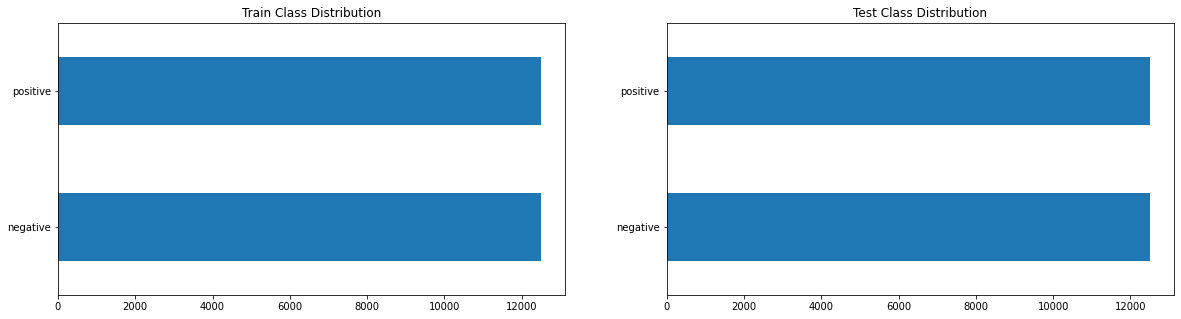

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
df_y_train = pd.DataFrame(y_train,columns=['label'])
df_y_train['sentiment'] = df_y_train['label'].apply(lambda x: 'positive' if x == 1 else 'negative')
df_y_train['sentiment'].value_counts().plot(kind='barh',title='Train Class Distribution',ax=ax[0])

df_y_test = pd.DataFrame(y_test,columns=['label'])
df_y_test['sentiment'] = df_y_test['label'].apply(lambda x: 'positive' if x == 1 else 'negative')
df_y_test['sentiment'].value_counts().plot(kind='barh',title='Test Class Distribution',ax=ax[1])

In [ ]:
print('Train Features shape:',X_train.shape)
print('Test Features shape:',X_test.shape)
print('Train label shape:',y_train.shape)
print('Test label shape:',y_test.shape)

Train Features shape: (40000,)
Test Features shape: (10000,)
Train label shape: (40000,)
Test label shape: (10000,)


## Data Pre-processing

In [ ]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/1",output_shape=128,
                           input_shape=[], dtype=tf.string, trainable=True)

model = keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 124,644,769
Trainable params: 2,081
Non-trainable params: 124,642,688
_________________________________________________________________


In [ ]:
# Configure  the model for training, by using appropriate optimizers and regularizations
# Available optimizer: adam, rmsprop, adagrad, sgd
# loss:  objective that the model will try to minimize. 
# Available loss: categorical_crossentropy, binary_crossentropy, mean_squared_error
# metrics: List of metrics to be evaluated by the model during training and testing. 
        
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [ ]:
x_val = X_train[:10000]
partial_x_train = X_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

In [ ]:
results = model.evaluate(test_data, test_labels)

print(results)

In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()